# DATA PREPROCESSING (ROCK PAPER SCISSORS)

In [ ]:
import os
from shutil import copyfile
import matplotlib.pyplot as plt
import numpy as np
import h5py 

%matplotlib inline

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/My Drive/rock-paper-scissors')

## Move all images to seperate class folders c0, c1 and c2 in a single folder D1

In [ ]:
# loop through each folder from D2-D8
folders = ['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8']
classes = ['c0', 'c1', 'c2']
for folder in folders[1:]:
    # loop through each class c0, c1 and c2 in each folder
    for cls in classes:
        print("=============================\n", f"{folder}/{cls}")
        # List of all images in folder/cls
        images = os.listdir(f"datasets/final/{folder}/{cls}")
        count = 0
        total = len(images)
        for img in images:
            # copy file to respective class folder in D1
            copyfile(f'datasets/final/{folder}/{cls}/{img}', f'datasets/final/D1/{cls}/{img}')
            count += 1
        print(f"{count}/{total}")

In [ ]:
total = 0
for cls in classes:
    num_images = len(os.listdir(f'datasets/final/D1/{cls}'))
    print(cls, ":", num_images)
    total += num_images
print("Total:", total)

c0 : 784
c1 : 738
c2 : 798
Total: 2320


## Visualising the images

In [ ]:

def display_grid(rows, cols, images, path=False, labels = [], preds=[], figsize=(20, 6)):
    """
    Displays images in a grid, given the image paths
    Parameters:
        *img_names: A sequence of absolute image paths
        rows: no. of rows in the grid
        cols: no. of cols in the grid
    Returns:
        displays the given images in a grid
    """
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    row, col = 0, 0
    
    if path:
        idx = 0
        for path in images:
            # Converting image to numpy array
            img_file = open(path, 'rb')
            img_array = plt.imread(img_file)

            # Axis properties
            axes[row, col].imshow(img_array)
            axes[row, col].set_xticks([])
            axes[row, col].set_yticks([])
            if preds!=[]:
                axes[row, col].set_title(f"Prediction: {preds[idx]}, Target: {labels[idx]}", color='white', fontsize=20)

            # Updating the grid coordinates row and col
            if col==cols-1:
                row+=1
                col=0
            elif row==rows-1:
                col+=1
            else:
                col+=1
            idx += 1
    else:
        row, col = 0, 0
        for i in range(images.shape[0]):
            # Axis properties
                axes[row, col].imshow(images[i, :, :, :])
                axes[row, col].set_xticks([])
                axes[row, col].set_yticks([])
                if labels != []:
                    title_num = int(labels[i])
                    if title_num==0:
                        title = 'ROCK'
                    elif title_num==1:
                        title = 'PAPER'
                    elif title_num==2:
                        title = 'SCISSORS'
                    axes[row, col].set_title(f'{i}=>{title}', color='red', fontsize=13)

                # Updating the grid coordinates row and col
                if col==cols-1:
                    row+=1
                    col=0
                elif row==rows-1:
                    col+=1
                else:
                    col+=1

The next task is to loop through each class folder in each folders D1-D7 and display one of those images from each class in a grid

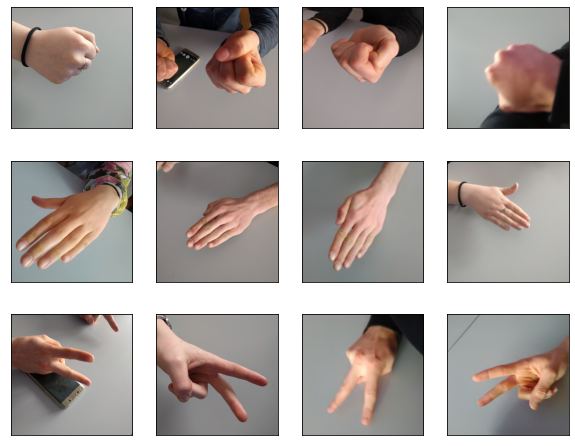

In [ ]:
# Folder and three classes in each folder
classes = ['c0', 'c1', 'c2']

path = 'datasets/final/D1'

# The list to store each image from the different folders in 
images = []

# Looping through each class c0-c2 in each folder D1-D7 and storing them in the list images
# There should be a total of 9*3 = 27 images
names = []
for cls in classes:
    folder_path = f"{path}/{cls}"
    images = os.listdir(folder_path)
    i = 0
    for img in images:
        names.append(f'{folder_path}/{img}')
        i+=1
        if i==4:
            break
display_grid(3, 4, images=names, path=True, figsize=(10, 8))

Each row above consists of 3 images from each class in the dataset.

## Data Preparation

In [ ]:
import torch
from torch.utils.data import Dataset
import torch.nn as nn

cuda_available = torch.cuda.is_available()
print("Is GPU available?\n", "Yes" if cuda_available else "No")

Is GPU available?
 Yes


In [ ]:
device = torch.device('cuda:0') if cuda_available else torch.device('cpu')
device

device(type='cuda', index=0)

In [ ]:
from torchvision import transforms

# Image transformations
image_transforms = {
    # Train uses data augmentation
    'train':
    transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  # Image net standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  # Imagenet standards
    ]),
    # Validation does not use augmentation
    'val':
    transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [ ]:
from torchvision import datasets
from torch.utils.data import DataLoader

traindir = 'datasets/final/D1'
valdir = 'datasets/final/validation' 

data = {
    'train':
    datasets.ImageFolder(root=traindir, transform=image_transforms['train']),
    'val':
    datasets.ImageFolder(root=valdir, transform=image_transforms['val'])
}

BATCH_SIZE = 4

dataloaders = {
    'train': DataLoader(data['train'], batch_size=BATCH_SIZE, shuffle=True),
    'val': DataLoader(data['val'], batch_size=BATCH_SIZE, shuffle=True)
}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Shape of images: torch.Size([4, 3, 224, 224]) 
Labels: tensor([2, 1, 0, 1])


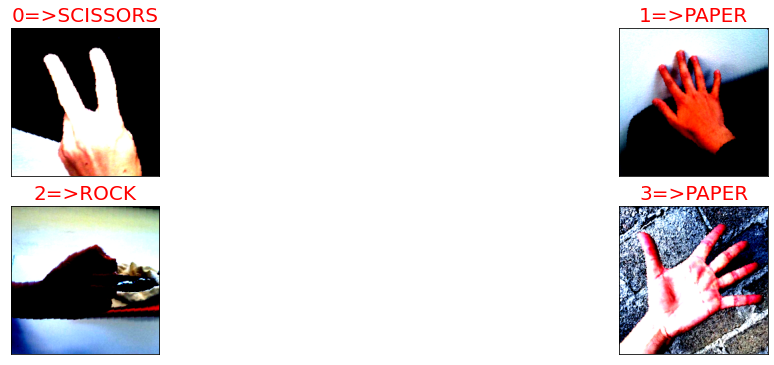

In [ ]:
for images, labels in dataloaders['train']:
    print("\nShape of images:", images.shape, "\nLabels:", labels)
    display_grid(rows=2, cols=2, images=images.permute(0, 2, 3, 1), labels=labels)
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Shapes: torch.Size([4, 3, 224, 224]) 
Labels: tensor([2, 1, 0, 0])


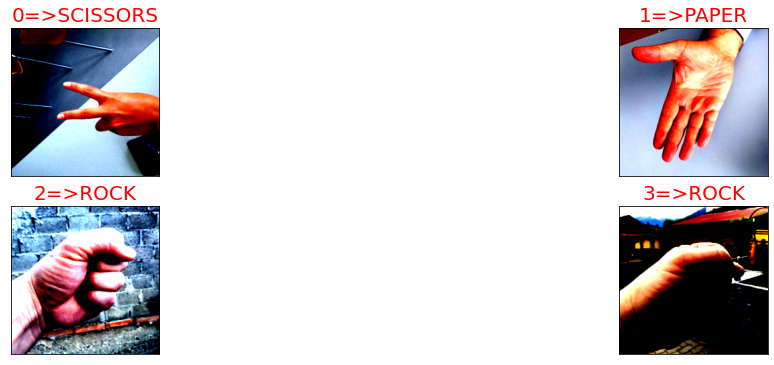

In [ ]:
for images, labels in dataloaders['val']:
    print("\nShapes:", images.shape, "\nLabels:", labels)
    display_grid(rows=2, cols=2, images=images.permute(0, 2, 3, 1), labels=labels)
    break

In [ ]:
from torchvision import models

def get_pretrained_model(model_name, parallel=True):
    """Retrieve a pre-trained model from torchvision

    Params
    -------
        model_name (str): name of the model (currently only accepts vgg16 and resnet50)

    Return
    --------
        model (PyTorch model): cnn

    """
    # if the model is 'vgg16':
    # freeze all layers
    # assign the no of input features to variable n_inputs
    # reset the last layer of the model a nn.Sequential layer
    if model_name == 'vgg16':
        model = models.vgg16(pretrained=True)

        # Freeze early layers
        for param in model.parameters():
            param.requires_grad = False
        n_inputs = model.classifier[6].in_features

        # Add on classifier
        model.classifier[6] = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))
    
    # if the model is 'resnet50':
    # freeze all layers
    # assign the no. of input features of the last layer to the variable n_inputs
    # reset the last layer so that we can train it on our dataset
    elif model_name == 'resnet50':
        model = models.resnet50(pretrained=True)

        for param in model.parameters():
            param.requires_grad = False

        n_inputs = model.fc.in_features
        model.fc = nn.Sequential(
            nn.Linear(n_inputs, 256), nn.ReLU(), nn.Dropout(0.2),
            nn.Linear(256, 3), nn.LogSoftmax(dim=1))

    # Move to gpu and parallelize
    model = model.to(device)
    if parallel:
        model = nn.DataParallel(model)

    return model

In [ ]:
model = get_pretrained_model('resnet50')
model

DataParallel(
  (module): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
      

In [ ]:

def train(model,
          criterion,
          optimizer,
          train_loader,
          valid_loader,
          max_epochs_stop=3,
          n_epochs=20,
          print_every=1):
    """Train a PyTorch Model

    Params
    --------
        model (PyTorch model): cnn to train
        criterion (PyTorch loss): objective to minimize
        optimizer (PyTorch optimizier): optimizer to compute gradients of model parameters
        train_loader (PyTorch dataloader): training dataloader to iterate through
        valid_loader (PyTorch dataloader): validation dataloader used for early stopping
        save_file_name (str ending in '.pt'): file path to save the model state dict
        max_epochs_stop (int): maximum number of epochs with no improvement in validation loss for early stopping
        n_epochs (int): maximum number of training epochs
        print_every (int): frequency of epochs to print training stats

    Returns
    --------
        model (PyTorch model): trained cnn with best weights
        history (DataFrame): history of train and validation loss and accuracy
    """

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf

    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')


    # Main loop
    for epoch in range(n_epochs):

        # keep track of training and validation loss each epoch
        train_loss = 0.0
        valid_loss = 0.0

        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()

        # Training loop
        for idx, (images, labels) in enumerate(train_loader):
            # Tensors to gpu
            images, labels = images.cuda(), labels.cuda()

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(images)

            # Loss and backpropagation of gradients
            loss = criterion(output, labels)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * images.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(labels.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * images.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (idx + 1) / len(train_loader):.2f}% complete.', end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for images, labels in valid_loader:
                    # Tensors to gpu
                    images, labels = images.to(device), labels.to(device)

                    # Forward pass
                    output = model(images)

                    # Validation loss
                    loss = criterion(output, labels)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * images.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(labels.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * images.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
                if (epoch + 1) % print_every == 0:
                    print(
                        f'\nEpoch: {epoch} \tTraining Loss: {train_loss:.4f} \tValidation Loss: {valid_loss:.4f}'
                    )
                    print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\t Validation Accuracy: {100 * valid_acc:.2f}%'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if int(epochs_no_improve) >= int(max_epochs_stop):
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
                        )


                        # Attach the optimizer
                        model.optimizer = optimizer

                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_acc:.2f}%'
    )

    return model, history

In [ ]:
import torch.optim as optim

criterion =nn.NLLLoss()
optimizer = optim.Adam(model.parameters())

In [ ]:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])

Starting Training from Scratch.


Epoch: 0 	Training Loss: 0.9681 	Validation Loss: 0.6127
		Training Accuracy: 51.55%	 Validation Accuracy: 68.82%

Epoch: 1 	Training Loss: 0.7998 	Validation Loss: 0.6097
		Training Accuracy: 63.19%	 Validation Accuracy: 68.82%

Epoch: 2 	Training Loss: 0.7375 	Validation Loss: 0.5049
		Training Accuracy: 66.42%	 Validation Accuracy: 79.57%

Epoch: 3 	Training Loss: 0.7056 	Validation Loss: 0.4547
		Training Accuracy: 68.32%	 Validation Accuracy: 89.25%

Epoch: 4 	Training Loss: 0.7157 	Validation Loss: 0.4761
		Training Accuracy: 68.49%	 Validation Accuracy: 80.65%

Epoch: 5 	Training Loss: 0.6845 	Validation Loss: 0.3376
		Training Accuracy: 70.99%	 Validation Accuracy: 90.32%

Epoch: 6 	Training Loss: 0.7213 	Validation Loss: 0.3805
		Training Accuracy: 69.27%	 Validation Accuracy: 81.72%

Epoch: 7 	Training Loss: 0.6429 	Validation Loss: 0.3669
		Training Accuracy: 72.16%	 Validation Accuracy: 86.02%

Epoch: 8 	Training Loss: 0.6678 	Validation Lo

In [ ]:
model, history = train(model, criterion, optimizer, dataloaders['train'], dataloaders['val'])

Model has been trained for: 9 epochs.


Epoch: 0 	Training Loss: 0.6788 	Validation Loss: 0.3661
		Training Accuracy: 71.90%	 Validation Accuracy: 88.17%

Epoch: 1 	Training Loss: 0.6527 	Validation Loss: 0.3031
		Training Accuracy: 71.94%	 Validation Accuracy: 89.25%

Epoch: 2 	Training Loss: 0.6402 	Validation Loss: 0.3557
		Training Accuracy: 72.97%	 Validation Accuracy: 83.87%

Epoch: 3 	Training Loss: 0.6541 	Validation Loss: 0.3616
		Training Accuracy: 72.07%	 Validation Accuracy: 89.25%

Epoch: 4 	Training Loss: 0.6637 	Validation Loss: 0.3524
		Training Accuracy: 70.43%	 Validation Accuracy: 84.95%

Early Stopping! Total epochs: 4. Best epoch: 1 with loss: 0.30 and acc: 84.95%


In [ ]:
# torch.save(model, 'models/resnet50-model-2.pt')

In [ ]:
model = torch.load('models/resnet50-model-2.pt')

In [ ]:
from PIL import Image

def predict(fnames, labels, model, nrows, ncols, figsize=(20, 10), root=None):
    label_words = []
    correct, wrong = 0, 0
    preds = []
    new_img_transform = transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    for fname, label in zip(fnames, labels):
        label_words.append('rock' if label==0 else 'paper' if label==1 else 'scissors')
        if root:
            img = Image.open(f'{root}/{fname}')
            fnames[fnames.index(fname)] = f'{root}/{fname}'
        else:
            img = Image.open(fname)
        input = new_img_transform(img)
        input = input.view(1, 3, 224, 224)
        with torch.no_grad():
            probs  = model(input.to(device))
            pred = torch.argmax(probs).item()
            if pred==label:
                correct += 1
            else:
                wrong += 1
            preds.append('rock' if pred==0 else 'paper' if pred==1 else 'scissors')

    print("Correct:", correct, ", Wrong:", wrong)
    display_grid(nrows, ncols, images=fnames, labels=label_words, preds=preds, path=True, figsize=figsize)

Correct: 18 , Wrong: 6


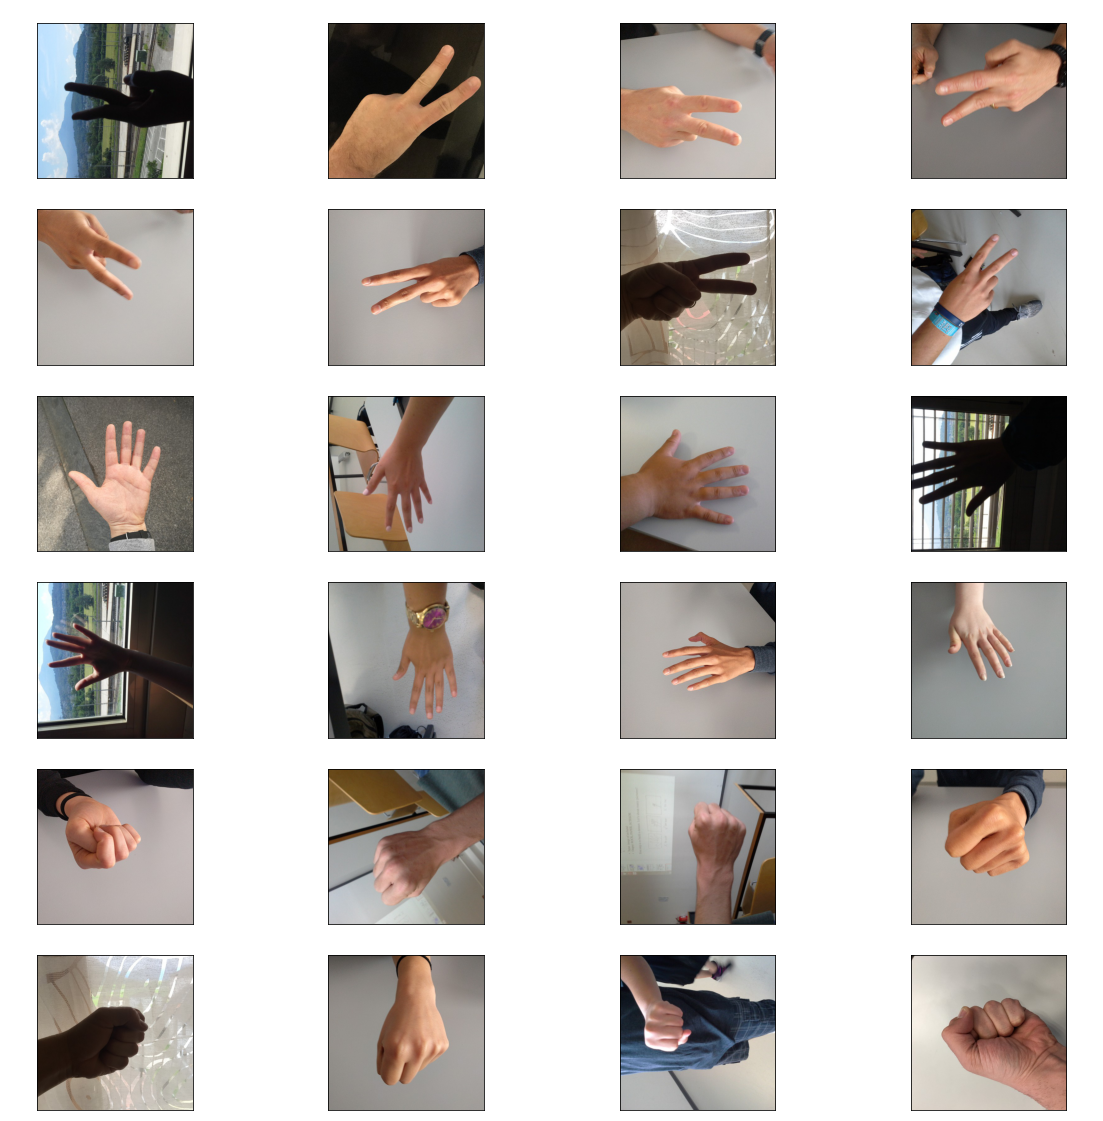

In [ ]:
val_images, val_labels = [], []
for cls in os.listdir('datasets/final/validation'):
    imgs = os.listdir(f'datasets/final/validation/{cls}')
    i=0
    for img in imgs:
        cls_num = 0 if cls=='c0' else 1 if cls=='c1' else 2
        val_labels.append(cls_num)
        val_images.append(f'{cls}/{img}')
        i+=1
        if i==8:
            break

predict(val_images, val_labels, model, 6, 4, figsize=(20, 20), root='datasets/final/validation')

Correct: 17 , Wrong: 1


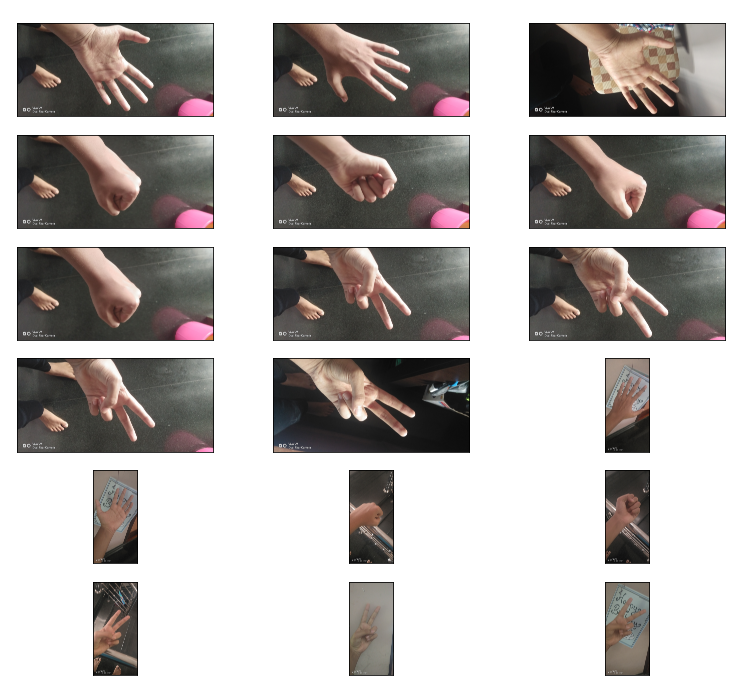

In [ ]:
phone_images = ['paper-1.jpg',
                'paper-2.jpg',
                'paper-3.jpg',
                'rock-1.jpg',
                'rock-2.jpg',
                'rock-3.jpg',
                'rock-1.jpg',
                'scissors-1.jpg',
                'scissors-2.jpg',
                'scissors-1.jpg',
                'scissors-4.jpg',
                '2-paper-1.jpg',
                '2-paper-2.jpg',
                '2-rock-1.jpg',
                '2-rock-2.jpg',
                '2-scissors-1.jpg',
                '2-scissors-2.jpg',
                '2-scissors-3.jpg'
]
labels = [1, 1, 1, 0, 0, 0, 0, 2, 2, 2, 2, 1, 1, 0, 0, 2, 2, 2]

predict(phone_images, labels, model, 6, 3, figsize=(13, 12), root='my-images')

Correct: 12 , Wrong: 0


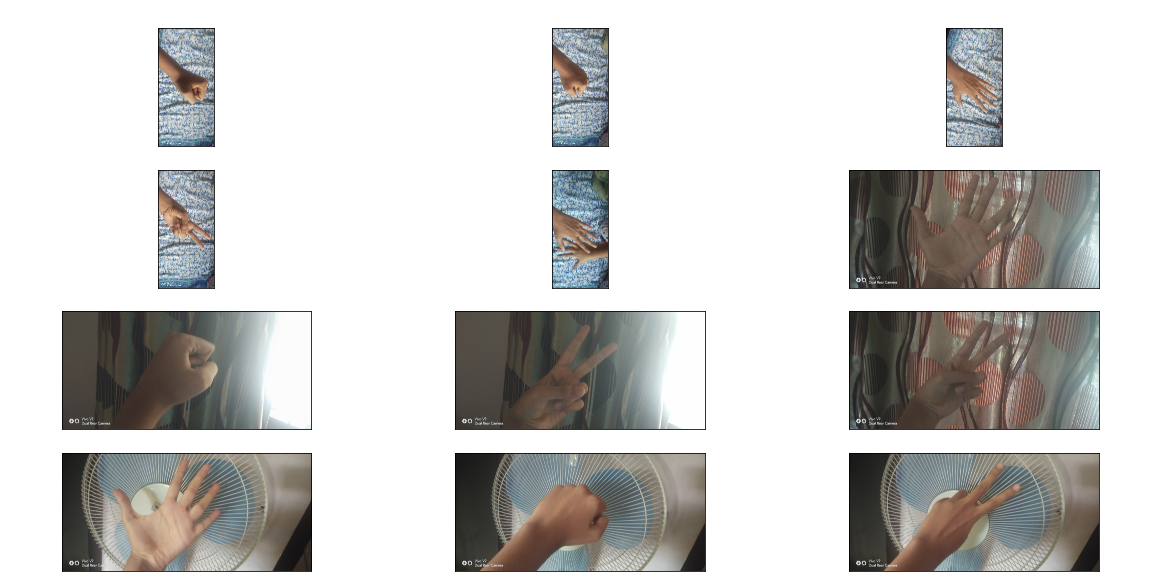

In [ ]:
colorful_images = ["bed-rock.jpg",
                   "bed-rock-2.jpg",
                   "bed-paper.jpg",
                   "bed-scissors.jpg",
                   "bed-two-paper.jpg",
                   "curtain-paper.jpg",
                   "curtain-rock.jpg",
                   "curtain-scissors.jpg",
                   "curtain-scissors-2.jpg",
                   "fan-paper.jpg",
                   "fan-rock.jpg",
                   "fan-scissors.jpg"
]
colorful_labels = [0, 0, 1, 2, 1, 1, 0, 2, 2, 1, 0, 2]

predict(colorful_images, colorful_labels, model, 4, 3, root='my-images')

## MODEL LOADING

In [ ]:
model = torch.load('models/resnet50-model-2.pt')

In [ ]:
imgs = list(os.listdir('../../..'))
imgs = [name for name in imgs if name[-3:]=="jpg"]

labels = []
for name in imgs:
    if "rock" in name:
        labels.append(0)
    elif "paper" in name:
        labels.append(1)
    elif "scissors" in name:
        labels.append(2)
len(imgs), len(labels)

(40, 40)

In [ ]:
predict(imgs, labels, model, 10, 4, figsize=(20, 30), root="../../..")

Correct: 35 , Wrong: 5


## ANDROID DEPLOYMENT

In [ ]:
model = torch.load("models/resnet50-model-2.pt")

In [ ]:
model.eval()
input_tensor = torch.rand(1,3,224,224)

script_model = torch.jit.trace(model.module,input_tensor.to(device))
script_model.save("classifier.pt")